# Consumer Sentiment vs Economic Data
Brian Dew

December 1, 2023

-----

See:

https://stayathomemacro.substack.com/p/most-americans-are-better-off-financially

https://www.washingtonpost.com/business/2023/11/24/bigmac-price-tiktok-biden-economy-inflation/

https://twitter.com/quantian1/status/1688397994821873664

https://twitter.com/Wertwhile/status/1729311763466752377

In [1]:
# Import libraries / preliminaries
%config Completer.use_jedi = False
import pandas as pd
import requests
import io, itertools, time
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
plt.rc('axes', edgecolor='lightgray')
plt.rc('ytick',labelsize=8)

# Header to retrieve flat files from BLS
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/110.0'}

# Recession start and end months, from NBER
rec_dt = [('1969-12-01', '1970-11-01'), ('1973-11-01', '1975-03-01'), 
          ('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'),
          ('1990-07-01', '1991-03-01'), ('2001-04-01', '2001-12-01'), 
          ('2008-01-01', '2009-07-01'), ('2020-02-01', '2020-04-01')]

# Function to retrieve a series from FRED
def fred_df(series):
    url = f'http://research.stlouisfed.org/fred2/series/{series}/downloaddata/{series}.csv'
    df = pd.read_csv(url, index_col='DATE', parse_dates=True, na_values=['.'])
    return df.rename({'VALUE': series}, axis=1)

## Latest vs Previous Economic Recoveries

In [2]:
# Retrieve Data
# Real GDP per capita
df = fred_df('A939RX0Q048SBEA')
# Unemployment rate
df2 = fred_df('UNRATE')

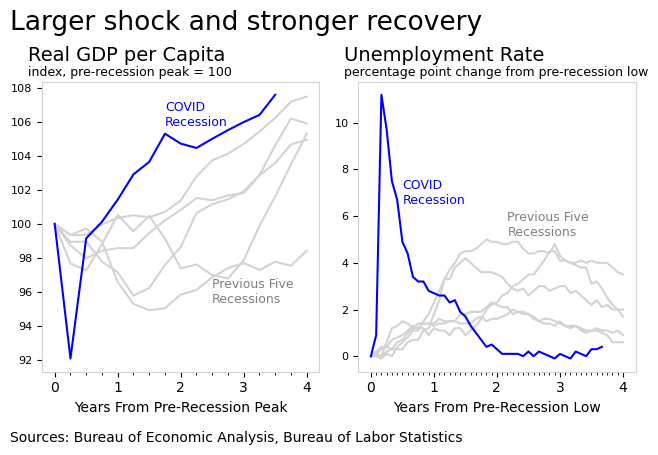

In [3]:
# Chart 1
# GDP recovery chart
dates = pd.to_datetime(['1973-10-01', '1980-01-01', '1990-07-01',
                        '2001-04-01', '2007-10-01', '2020-01-01'])
res = pd.DataFrame()
for date in dates:
    res[date] = (df.loc[date:].iloc[:17] / 
                 df.loc[date]).reset_index()['A939RX0Q048SBEA'] * 100
res.index.name = 'Years From Pre-Recession Peak'

# Unemployment recovery chart
dates = ['1973-11-01', '1980-01-01', '1990-07-01',
         '2001-03-01', '2007-12-01', '2020-02-01']
res2 = pd.DataFrame()
for date in dates:
    res2[date] = (df2.loc[date:].iloc[:49] - df2.loc[date]).reset_index()['UNRATE']
    
# Chart 1
rcolor = 'blue'
colors = ['lightgray']*5 + [rcolor]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
res.index.name = 'Years From Pre-Recession Peak'
res2.index.name = 'Years From Pre-Recession Low'
res.plot(color=colors, legend=False, ax=ax1)
res2.plot(color=colors, legend=False, ax=ax2)
ax1.text(-0.05, 1.07, 'Real GDP per Capita', size=14, transform=ax1.transAxes)
ax1.text(-0.05, 1.02, 'index, pre-recession peak = 100', size=9, transform=ax1.transAxes)
ax1.text(7, 106.4, 'COVID\nRecession', va='center', size=9, color=rcolor)
ax1.text(10, 96, 'Previous Five\nRecessions', va='center', 
         size=9, color='gray')
ax1.set_xticks([0, 4, 8, 12, 16])
ax1.set_xticks(list(res.index), minor=True)
ax2.set_xticks([0, 12, 24, 36, 48])
ax2.set_xticks(list(res2.index), minor=True)
xticks = ['0', '1', '2', '3', '4']
ax1.set_xticklabels(xticks)
ax2.set_xticklabels(xticks)
ax2.text(-0.05, 1.07, 'Unemployment Rate', size=14, transform=ax2.transAxes)
ax2.text(-0.05, 1.02, 'percentage point change from pre-recession low', size=9, transform=ax2.transAxes)
ax2.text(6, 7, 'COVID\nRecession', va='center', size=9, color=rcolor)
ax2.text(26, 5.6, 'Previous Five\nRecessions', va='center', 
         size=9, color='gray')

# Figure title and footer
title = ('Larger shock and stronger recovery')
fig.text(0.02, 1.0, title, fontsize=19)
footer = ('Sources: Bureau of Economic Analysis, Bureau of Labor Statistics')
fig.text(0.02, -0.03, footer, fontsize=10)  
# Adjust layout
plt.tight_layout()
plt.savefig('econ_recovery.png', bbox_inches='tight')
plt.show()

## How well do basic economic indicators explain consumer sentiment?

In [4]:
# Settings for chart show consumer sentiment model prediction
def cs_model_chart(df, fname, start='2018', end='2023-12-01', title='', subtitle='',
                   height=3, width=7, modeldate='1988', r2='', r2y=5):
    dft = df.loc[start:]
    colors = ['magenta', 'midnightblue']

    fig, ax = plt.subplots(1, 1, figsize=(width, height))
    dft['UMCSENT'].plot(color=colors[1], lw=1.6, ax=ax)
    dft['Predicted'].plot(color=colors[0], lw=1.2, ls='--', ax=ax)
    # Recession bars
    for r_start, r_end in rec_dt:
        ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
    # Title
    fig.text(0.03, 1.03, title, fontsize=15)
    fig.text(0.04, 0.97, subtitle, fontsize=9, style='italic')
    ax.set_ylim(0, 130)
    ax.set_xlim(start, end)
    dt_rng = pd.date_range(start=start, end=end, freq='MS')
    
    xticks = [str(dt.year) for dt in dt_rng 
              if (dt.year % 5 == 0) & (dt.month == 1)]        
    # X ticks
    ax.set_xticks([dt for dt in dt_rng 
                   if (dt.year % 5 == 0) & (dt.month == 1)])
    ax.set_xticklabels(xticks, rotation=0, ha='center', fontsize=8)
    ax.set_xticks([dt for dt in dt_rng
                    if dt.month == 1], minor=True)
    # Mark sample bounds
    ax.axvline('2019-12-01', linestyle='--', lw=0.8, color='dimgray', zorder=0)
    ax.text('2020-03-01', 112, 'out of\nsample\nfit', size=8)
    if modeldate > start:
        ax.axvline(modeldate, linestyle='--', lw=0.8, color='dimgray', zorder=0)
        ax.text(modeldate, 112, 'out of \nsample \nfit ', size=8, ha='right')
    # Optional add r^2
    if r2 != '':
        ax.text(modeldate, r2y, 
                f'  In-Sample $R^2$: {r2:.2f}', size=9)
    # legend
    ax.legend(edgecolor='lightgray', bbox_to_anchor=(0, 0), 
              loc='lower left', fontsize=9)
    plt.tight_layout()
    plt.savefig(f'{fname}.png', bbox_inches='tight')
    plt.show()

In [5]:
# Retrieve Data
# SP500 and DXY 
ltdate = int(time.time())
rn = {'%5EGSPC': 'SP500', 'DX-Y.NYB': 'DXY'}
yfd = pd.DataFrame()
for s in ['%5EGSPC', 'DX-Y.NYB']:
    url = ('https://query1.finance.yahoo.com/v7/finance/download/'+
           f'{s}?period1=-186883200&period2={ltdate}&'+
            'interval=1d&events=history')
    r = pd.read_csv(url, index_col='Date', parse_dates=True)
    yfd[s] = r['Adj Close'].resample('MS').mean()
yfd = yfd.rename(rn, axis=1)

# Retrieve various series from FRED
srs = ['UMCSENT', 'CPIAUCSL', 'DGS10', 'DSPI', 'CPIENGSL',
       'FEDFUNDS', 'UNRATE', 'AHETPI', 'ASPNHSUS', 'CUSR0000SAH1', 
       'MORTGAGE30US', 'AWHNONAG', 'PAYEMS', 'A576RC1']
data = pd.concat([fred_df(s) for s in srs], axis=1)
data = pd.concat([data, yfd], axis=1)

# Clean and adjust data 
df = data.copy()
# Price Deflator
pr = df['CPIAUCSL'].dropna()
defl = pr.iloc[-1] / pr

# Inflation - CPI YoY
df['CPI'] = pr.pct_change(12) * 100
# Housing Prices 1 - CPI Shelter Index YoY
df['HP_CPI'] = df['CUSR0000SAH1'].dropna().pct_change(12) * 100
# Housing Prices 2 - Average New Home Sales Price YoY
df['HP_NHS'] = (df['ASPNHSUS'].dropna().pct_change(12) * 100)
# Real Wage YoY
df['RW'] = np.log(df['AHETPI'] * defl).dropna().diff(12) * 100
# Gross Labor Income YoY
df['GLI'] = ((df['AHETPI'] * df['PAYEMS'] * df['AWHNONAG'])
               .dropna().pct_change(12) * 100).ffill()
# Dollar YoY
df['USD'] = df['DXY'].dropna().pct_change(12) * 100
# Fed Funds Rate, 10Y Treasury, 30Y Mortgage as monthly averages
for s in ['FEDFUNDS', 'DGS10', 'MORTGAGE30US']:
    df[s] = df[s].dropna().resample('MS').mean()
# S&P 500 YoY
df['SP500'] = df['SP500'].dropna().pct_change(12) * 100
# Energy
df['EnergyGR'] = df['CPIENGSL'].dropna().pct_change(12) * 100
# Disposable Personal Income Growth
df['DSPIgr'] = df['DSPI'].dropna().pct_change(12) * 100

# Deviation from past 10 year average 
devvars = ['UNRATE', 'CPI', 'FEDFUNDS', 'DGS10']
devcols = {c: f'{c}_DEV' for c in devvars}
for col, name in devcols.items():
    c = df[col].dropna()
    df[f'{col}_DEV'] = c - c.rolling(120).mean().dropna()

# Constant
df['Constant'] = 100

# Store predictions for each model variation
Pred = {}

### Models

In [19]:
# Various models of Consumer Sentiment
# Model 1 
xlist1 = ['Constant', 'CPI', 'UNRATE', 'HP_CPI', 'GLI', 
         'SP500', 'FEDFUNDS', 'DGS10']
full1 = df[xlist1 + ['UMCSENT']].dropna()
tsamp1 = full1.loc['1979':'2019'] # Training sample

# Fit the model to the training sample
model1 = sm.OLS(tsamp1.UMCSENT, tsamp1[xlist1])
result1 = model1.fit()
pred1 = result1.predict(full1[xlist1])
Pred['Model1'] = pred1.loc['2023-08-01': '2023-10-01'].mean()


# Model 1B = Start in 1988 
tsamp1b = full1.loc['1988':'2019'] # Training sample starts 1988

# Fit the model to the training sample
model1b = sm.OLS(tsamp1b.UMCSENT, tsamp1b[xlist1])
result1b = model1b.fit()
pred1b = result1b.predict(full1[xlist1])
Pred['Model1B'] = pred1b.loc['2023-08-01': '2023-10-01'].mean()


# Model 1C += Deviation Variables
xvars1c = ['CPI_DEV', 'UNRATE_DEV', 'DGS10_DEV']
xlist1c = xlist1 + xvars1c
full1c = df[xlist1c + ['UMCSENT']].dropna()
tsamp1c = full1c.loc['1988': '2019']

# Fit the model to the training sample
model1c = sm.OLS(tsamp1c.UMCSENT, tsamp1c[xlist1c])
result1c = model1c.fit()
pred1c = result1c.predict(full1c[xlist1c])
Pred['Model1C'] = pred1c.loc['2023-08-01': '2023-10-01'].mean()


# Model 2 += Price Adjustments 
xvars2 = ['EnergyGR', 'HP_NHS']
xlist2 = [x for x in xlist1c if x != 'HP_CPI']  + xvars2
full2 = df[xlist2 + ['UMCSENT']].dropna()
tsamp2 = full2.loc['1988': '2019']

# Fit the model to the training sample
model2 = sm.OLS(tsamp2.UMCSENT, tsamp2[xlist2])
result2 = model2.fit()
pred2 = result2.predict(full2[xlist2])
Pred['Model2'] = pred2.loc['2023-08-01': '2023-10-01'].mean()

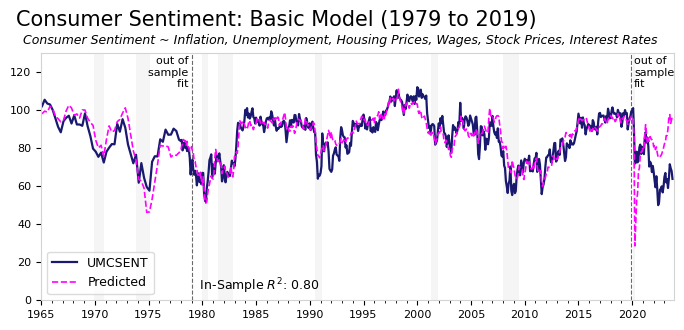

In [20]:
# Chart 2
pred1.name = 'Predicted'
res = pd.concat([pred1, full1['UMCSENT']], axis=1)
title = 'Consumer Sentiment: Basic Model (1979 to 2019)'
subtitle = ('Consumer Sentiment ~ Inflation, Unemployment, Housing '+
            'Prices, Wages, Stock Prices, Interest Rates')
cs_model_chart(res, start='1965', title=title, subtitle=subtitle, 
               modeldate='1979', r2=result1.rsquared_adj, r2y=5, 
               fname='model1')

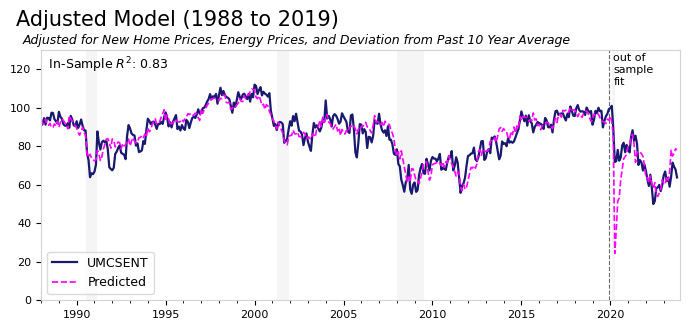

In [21]:
# Chart 3
pred2.name = 'Predicted'
res = pd.concat([pred2, full2['UMCSENT']], axis=1)
title = 'Adjusted Model (1988 to 2019)'
subtitle = ('Adjusted for New Home Prices, Energy Prices, and '+
            'Deviation from Past 10 Year Average')
cs_model_chart(res, start='1988', title=title, subtitle=subtitle, 
               modeldate='1988', r2=result2.rsquared_adj, r2y=120,
               fname='model2')

In [18]:
Pred

{'Model1': 95.07210099168005,
 'Model1B': 90.52943311475002,
 'Model1C': 82.01835175501623,
 'Model2': 77.74785718294872}

In [17]:
pd.Series(Pred).diff()

Model1          NaN
Model1B   -4.542668
Model1C   -8.511081
Model2    -4.270495
dtype: float64